# Convolutional Neural Network 

**Concepts only - Implementation without using any framework or libraries**
```
- Forward Softmax, Backward Softmax, Backward Relu, Forward Convolution, 
- Backward Convolution, Forward Max Pool Layering, Backward Max Pool Layering,
- Forward Cross Entropy Loss, Forward Linear, Backward Linear, 
- Forward Propagation, Backward Propagation, Forward Prop Batch 
- Gradient Descent Batch, Train/Test, Compute Accuracy and Run-through
```

In [42]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import argparse
import functools

In [43]:
def forward_softmax(x):
  """
  Compute softmax function for a single example
  The input x, 1d float numpy has shape that is the size of number of classes 
  Returns 1d numpy float that has the softmax results of shape number of classes
  """
  x = x - np.max(x, axis=0)
  exp_x = np.exp(x)
  softmax_ = exp_x / np.sum(exp_x, axis=0)
  
  return softmax_

In [44]:
def backward_softmax(x, gradient_of_outputs): 
  """
  Compute the gradient of the loss with respect to x
  gradient-output is the gradient of the loss with respect to the outputs 
  of softmax, and 1d numpy float array of shape number of classes 
  """
  probabilities = forward_softmax(x)
  gradient_of_x = np.zeros(x.shape)

  for i in range(gradient_of_outputs.shape[0]):
    for j in range(gradient_of_outputs.shape[0]):
      if i == j :
        gradient_of_x[i] += \
            probabilities[i] * (1- probabilities[j])*gradient_of_outputs[j]      
      else:
        gradient_of_x[i] += \
           -probabilities[i] * probabilities[j] * gradient_of_outputs[j]
  
  return gradient_of_x

In [76]:
def forward_relu(x):
  """
  Compute the Relu function for the input x 
  Returns numpy float array containing relu results 
  """
  x[x<=0] = 0 

  return x 

In [84]:
def backward_relu(x, gradient_of_outputs):
  """ 
  Compute the gradient of the loss with respect to x 
  x of arbitrary shape 
  gradient-of-outputs of the same shape of x with the gradient of the loss with
  respect to the output of Relu 
  """
  x[x<=0] = 0 
  x[x>0] = 1 
  r_ = x * gradient_of_outputs

  return r_

In [85]:
""" Define Constants """ 
CONVOLUTION_SIZE = 4
CONVOLUTION_FILTERS = 2 
MAX_POOL_SIZE = 5 

In [86]:
def get_initial_params(): 
  """ 
  A function to initialize model parameters 
  A dictionary mapping of parameter names to numpy arrays containing the inital
  values for those parameters. 
    - W1 the weight matrix for the hidden layer of size input_size x num_hidden
    - b1 is the bias vector for the hidden layer of size num_hidden 
    - W2 the weight matrix for the output layers of size num_hidden x num_output 
    - b2 the vector for the output layer of size num_output 
    Weight matrices are initialized with random normal distribution 
    The mean of the distribution should be 0 
    The variance of that distribution should be 1/sqrt(n) where n is the number 
    of neurons that feed into the output for that layer 
    Bias vectors should be initialized with zero 
  """
  dimension_after_convolution = 28 - CONVOLUTION_SIZE + 1 
  dimension_with_maxpooling = dimension_after_convolution // MAX_POOL_SIZE
  num_hidden = \
    dimension_with_maxpooling * dimension_with_maxpooling * CONVOLUTION_FILTERS
  
  params = {
      'W1': np.random.normal(
              size=(CONVOLUTION_FILTERS, 1, CONVOLUTION_SIZE, CONVOLUTION_SIZE), 
              scale=1/math.sqrt(CONVOLUTION_SIZE*CONVOLUTION_SIZE)), 
      'b1': np.zeros(CONVOLUTION_FILTERS),
      'W2': np.random.normal(size=(num_hidden,10),scale=1/math.sqrt(num_hidden)),
      'b2': np.zeros(10)
  } 

  return params

In [75]:
def forward_convolution(conv_layer_Weights, conv_layer_bias, conv_layer_data):
  """
  Compute the output from a convolutional layer 
  convolutional_layer_Weights of shape:
    number-of-input-channels, convolution width and height 
  convolutional_layer_bias of shape:
    number-of-output-channels
  convolutional_layer_data of shape:
    number-of-input-channels, width and height
  convolutional_layer_output, result of convolution, of shape:
    number-of-output-channels, width - convolution width +1, 
                               height - convolution height +1
  """
  conv_channels, _, conv_width, conv_height = conv_layer_Weights.shape
  input_channels, input_width, input_height = conv_layer_data.shape 
  conv_output = np.zeros(
      (conv_channels, input_width-conv_width +1, input_height-conv_height +1))
  
  for x in range(input_width - conv_width + 1):
    for y in range(input_height - conv_height + 1):
      for output_channel in range(conv_channels):
        # convolution_output = np.sum(np.multiply(Data, Weights) + bias)
        conv_output[output_channel, x, y] = np.sum(np.multiply(
            conv_layer_data[:, x:(x + conv_width), y:(y + conv_height)], 
            conv_layer_Weights[output_channel,:,:,:])) + conv_layer_bias[output_channel]
  
  return conv_output

In [98]:
def backward_convolution(conv_layer_Weights, conv_layer_bias, conv_layer_data,
                         output_gradient):
  """ 
  Compute gradient of the loss with respect to the parameters of the convolution
  In forward-convolution, output-gradient is the gradient of the loss with 
  respect to the output of the convolution
  Returns a tuple of three gradients 
    - the gradient of the loss with respect to the convolution weights
    - the gradient of the loss with respect to the convolution bias 
    - the gradient of the loss with respect to the inputput data 
  """ 
  conv_channels, _, conv_width, conv_height = conv_layer_Weights.shape 
  input_channels, input_width, input_height = conv_layer_data.shape 
  bias_gradient = np.zeros(conv_layer_bias.shape)
  weights_gradient = np.zeros(conv_layer_Weights.shape)
  data_gradient = np.zeros(conv_layer_data.shape)

  for x in range(input_width - conv_width + 1):
    for y in range(input_height - conv_height +1):
      for output_channel in range(conv_channels):
        bias_gradient[output_channel] += output_gradient[output_channel, x, y]
        weights_gradient[output_channel, :, :, :] += \
          conv_layer_data[:, x:(x + conv_width), y:(y + conv_height)] * \
          output_gradient[output_channel, x, y]
        data_gradient[:, x:(x + conv_width), y:(y + conv_height)] += \
          conv_layer_Weights[output_channel, :, :, :] * \
          output_gradient[output_channel, x, y]
  
  return weights_gradient, bias_gradient, data_gradient 

In [88]:
def forward_max_pool(data, pool_width, pool_height): 
  """ 
  Compute the output from a max pooling layer given the data and pool dimensions
  The stride length should be equal to the pool size 
  data is of shape (number-of-channels, width, height)
  The output should be the result of the max pooling layer and should be of size:
    (number-of-channels, width // pool_width, height // pool_height)
  Returns the result of the max pooling layer 
  """
  input_channels, input_width, input_height = data.shape
  output = np.zeros((input_channels, input_width // pool_width, 
                     input_height // pool_height))
  
  for x in range(0, input_width, pool_width):
    for y in range(0, input_height, pool_height):
      output[:, x // pool_width, y // pool_height] = np.amax(
          data[:, x:(x + pool_width), y:(y + pool_height)], axis=(1,2))

  return output 

In [52]:
def backward_max_pool(data, pool_width, pool_height, output_gradient): 
  """ 
  Compute the gradient of the loss with respect to data in the max pool layer 
  data is of shape [number-of-channels, width, height] 
  output-gradient is the gradient of the loss with respect to the output of the
  backward max pool layer, and is of shape 
    [number-of-channels, width//pool_width, height/pool_height]]
  Returns the gradient of the loss with respectto the data, of same shape 
  """
  input_channels, input_width, input_height = data.shape
  data_gradient = np.zeros(data.shape)

  for x in range(0, input_width, pool_width):
    for y in range(0, input_height, pool_height):
      for channel in range(input_channels):
        max_index = np.argmax( 
            data[channel, x:(x + pool_width), y:(y + pool_height)])
        i, j = np.unravel_index(max_index, (pool_width, pool_height))
        data_gradient[channel, x +i, y +j] += output_gradient[
            channel, x // pool_width, y // pool_height]
  
  return data_gradient 

In [53]:
def forward_cross_entropy_loss(probabilities, labels): 
  """ 
  Compute the output from a cross entropy loss layer given 
  the probabilities and labels, of shape number of classes
  Return the output as a scalar, the result of the log loss layer 
  """
  result = 0 
  for i, label in enumerate(labels):
    if label == 1: 
      result += -np.log(probabilities[i])
  return result 

In [54]:
def backward_cross_entropy_loss(probabilities, labels): 
  """ 
  Compute the output from a cross entropy loss with respect to the probsbilities
  the probabilities and labels, of shape number of classes
  Return the gradient of the loss with respect to the probabilities 
  """
  gradient_probabilities = np.zeros(probabilities.shape)
  for i, label in enumerate(labels):
    if label == 1: 
      gradient_probabilities[i] = -1 / probabilities[i]
  return gradient_probabilities

In [83]:
def forward_linear(weights, bias, data):
  """ 
  Compute the output from a linear layer with the given weights, bias and data 
  weights is shape (input-number-of-features, output-number-of-features)
  bias is of shape (output-number-of-features)
  data is of shape (input number of features)
  Returns the result of the linear layer, of shape output-number-pf-features 
  """
  s = data.dot(weights) + bias 
  return s

In [56]:
def backward_linear(weights, bias, data, output_gradient):
  """ 
  Compute the gradients of the loss with respect to the params of a linear layer
  Return a tuple of three elements:
    - the gradient of the loss with respect to the weights 
    - the gradient of the loss with respect to the bias 
    - the gradient of the loss with respect to the data  
  """ 
  bias_gradient = output_gradient 
  weights_gradient = np.outer(data, output_gradient)
  data_gradient = np.dot(weights, output_gradient)

  return weights_gradient, bias_gradient, data_gradient 

In [57]:
def forward_prop(data, labels, params):
  """ 
  Implement the forward layer given the data, labels, and parameters 
  data: numpy 1d array of shape 1x28x28 
  labels: numpy 1d array containing labels of shape 10 
  params: dictionary mapping parameters to numpy arrays with parameters 
    - W1, b1, W2, and b2 
    - W1 and b1 represent the weights and bias for the hidden layer of network 
    - W2 and b2 represent the weights and bias for the output layer of network 
  Returns a tuple containing
    - numpy array, utput after softmax of output layer 
    - average loss for these data elements 
  """ 
  W1 = params['W1'] 
  b1 = params['b1']
  W2 = params['W2']
  b2 = params['b2']

  first_convolution = forward_convolution(W1, b1, data)
  first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
  first_after_relu = forward_relu(first_max_pool)

  flattened = np.reshape(first_after_relu, (-1))
  logits = forward_linear(W2, b2, flattened)

  y = forward_softmax(logits)
  cost = forward_cross_entropy_loss(y, labels)

  return y, cost 

In [93]:
def backward_prop(data, labels, params):
  """ 
  Compute the backward propagation gradient step for a neural network 
  data: numpy array of the input for a single example 
  labels: 1d numpy array of labels for a single example 
  params: dictionary mapping parameter nmes to numpy arrays with the params 
    - W1, b1, W2, b2 
    - W1 and b1 represent the weights and bias for the convolution layer 
    - W2 and b2 represent the weights and bias for the output layer of network 
  Returns dictionary of strings to numpy arrays where each key represents the 
  name of a weight, and the values represent the gradient of the loss with 
  respect to that weight 
    - W1, W2, b1 and b2 
  """
  W1 = params['W1'] 
  b1 = params['b1'] 
  W2 = params['W2'] 
  b2 = params['b2']  

  first_convolution = forward_convolution(W1, b1, data)
  first_max_pool = forward_max_pool(
                        first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
  first_after_relu = forward_relu(first_max_pool)

  flattened = np.reshape(first_after_relu, (-1))
  logits = forward_linear(W2, b2, flattened)
  y = forward_softmax(logits) 
  cost = forward_cross_entropy_loss(y, labels)
  y_gradient = backward_cross_entropy_loss(y, labels)
  logits_gradient = backward_softmax(logits, y_gradient)

  W2_gradient, b2_gradient, flattened_gradient = backward_linear(
                  W2, b2, flattened, logits_gradient)
  
  first_after_relu_gradient = flattened_gradient.reshape(first_after_relu.shape)
  first_max_pool_gradient = backward_relu(
                  first_max_pool, first_after_relu_gradient)
  first_convolution_gradient = backward_max_pool(
      first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE, first_max_pool_gradient)
  
  W1_gradient, b1_gradient, _ = backward_convolution(
                  W1, b1, data, first_convolution_gradient) 
  return {
      'W1': W1_gradient, 
      'b1': b1_gradient, 
      'W2': W2_gradient, 
      'b2': b2_gradient, 
      'y_gradient': y_gradient
  }

In [59]:
def forward_prop_batch(batch_data, batch_labels, params, forward_prop_func):
  """ Apply the forward-prop to every image in the batch set """ 
  y_array = []
  cost_array = []
  for item, label in zip(batch_data, batch_labels):
    y, cost = forward_prop_func(item, label, params)
    y_array.append(y)
    cost_array.append(cost)
  
  return np.array(y_array), np.array(cost_array)

In [60]:
def gradient_descent_batch(batch_data, batch_labels, learning_rate, 
                           params, backward_prop_func):
  """ 
  Perform one batch of gradient descent on the given training data using 'lr'
  It updates the parameters in the params 
  - batch-data a numpy containing the training data per batch 
  - train-labels a numpy array containing the training labels for the batch 
  - learning rate 
  - params - dictionary of params names to parameter values to be updated 
  - backward-prop-func to follows backward-prop API 
  """
  total_gradient = {}

  for i in range(batch_data.shape[0]):
    gradient = backward_prop_func(
        batch_data[i, :, :], 
        batch_labels[i, :], 
        params) 
    for key, value in gradient.items():
      if key not in total_gradient:
        total_gradient[key] = np.zeros(value.shape)
      total_gradient[key] += value 
  
  params['W1'] = params['W1'] - learning_rate * total_gradient['W1']
  params['W2'] = params['W2'] - learning_rate * total_gradient['W2']
  params['b1'] = params['b1'] - learning_rate * total_gradient['b1']
  params['b2'] = params['b2'] - learning_rate * total_gradient['b2']

  return 

In [110]:
def neural_network_train(
  train_data, train_labels, dev_data, dev_labels, 
  get_initial_params_func, forward_prop_func, backward_prop_func,
  learning_rate=5, batch_size=16, num_batches=400):
  """
  Train model using gradient descent for specified number of epochs.
  Evaluates loss and accuracy on training and dev set 
  -- at the end of each epoch --
  train_data and train_labels: numpy arrays 
  """
  n = train_data.shape[0]
  params = get_initial_params_func()

  cost_train, cost_dev = [], []
  accuracy_train, accuracy_dev = [], []
  for batch in range(num_batches):
    if batch % 10 == 0:
      print('Currently processing {} / {} '.format(batch, num_batches))
    batch_data = train_data[batch*batch_size: (batch +1)*batch_size, :, :, :]
    batch_labels = train_labels[batch*batch_size: (batch +1)*batch_size, :] 
    if batch % 100 == 0:
      output_d, cost_d = forward_prop_batch(
          dev_data, dev_labels, params, forward_prop_func)
      cost_dev.append(sum(cost_d) / len(cost_d))
      accuracy_dev.append(compute_accuracy(output_d, dev_labels))

      output_t, cost_t = forward_prop_batch(
          train_data, train_labels, params, forward_prop_func)
      cost_train.append(sum(cost_t) / len(cost_t))
      accuracy_train.append(compute_accuracy(output_t, train_labels))
      
      print('Cost and accuracy', cost_dev[-1], accuracy_dev[-1])

    gradient_descent_batch(
        batch_data, batch_labels, learning_rate, params, backward_prop_func)
  
  return params, cost_train, cost_dev, accuracy_train, accuracy_dev 


In [62]:
def neural_network_test(data, labels, params):
  output, cost = forward_prop(data, labels, params)
  accuracy = compute_accuracy(output, labels)

  return accuracy 

In [63]:
def compute_accuracy(output, labels):
  correct_output = np.argmax(output, axis=1)
  correct_labels = np.argmax(labels, axis=1)
  is_correct = [a == b for a, b in zip(correct_output, correct_labels)]
  accuracy = sum(is_correct) * 1./labels.shape[0]

  return accuracy 

In [64]:
def one_hot_labels(labels):
  """ Convert labels from integers to one hot encoding """
  one_hot_labels = np.zeros((labels.size, 10))
  one_hot_labels[np.arange(labels.size), labels.astype(int)] = 1
  
  return one_hot_labels 

In [13]:
from google.colab import files
files.upload()

Saving images_test.csv.gz to images_test.csv.gz
Saving images_train.csv.gz to images_train.csv.gz
Saving labels_test.csv.gz to labels_test.csv.gz
Saving labels_train.csv.gz to labels_train.csv.gz


In [14]:
!gzip -d images_test.csv.gz
!gzip -d images_train.csv.gz
!gzip -d labels_train.csv.gz
!gzip -d labels_test.csv.gz

In [65]:
def read_from_file(images_file, labels_file):
  """ load images and labels """ 
  x = np.loadtxt(images_file, delimiter=',')
  y = np.loadtxt(labels_file, delimiter=',') 
  x = np.reshape(x, (x.shape[0], 1, 28, 28))
  
  return x, y

In [109]:
def run_train(all_data, all_labels, backward_prop_func):
  
  params, cost_train, cost_dev, accuracy_train, accuracy_dev = \
      neural_network_train(
          all_data['train'], all_labels['train'],
          all_data['dev'], all_labels['dev'],
          get_initial_params, forward_prop, backward_prop_func, 
          learning_rate=1e-2, batch_size=16, num_batches=400)
  
  t = np.arange(400 // 100)
  fig_, (ax1, ax2) = plt.subplots(2, 1)

  ax1.plot(t, cost_train, 'r', label='train')
  ax1.plot(t, cost_dev, 'b', label='dev')
  ax1.set_xlabel('time')
  ax1.set_ylabel('loss')
  ax1.set_title('Training curve')

  ax2.plot(t, accuracy_train, 'r', label='train')
  ax2.plot(t, accuracy_dev, 'b', label='dev')
  ax2.set_xlabel('time')
  ax2.set_ylabel('accuracy')
  fig_.savefig('train.pdf')

In [ ]:
np.random.seed(100)
train_data, train_labels = read_from_file('images_train.csv', 'labels_train.csv')
train_labels = one_hot_labels(train_labels)
perm = np.random.permutation(60000)
train_data = train_data[perm, :]
train_labels = train_labels[perm, :]

dev_data = train_data[0:400, :]
dev_labels = train_labels[0:400, :]
train_data = train_data[400:, :]
train_labels = train_labels[400:, :]

mean = np.mean(train_data)
std = np.std(train_data)
train_data = (train_data - mean) / std 
dev_data = (dev_data - mean) / std 

all_data = {
    'train': train_data, 
    'dev': dev_data}
all_labels = {
    'train': train_labels, 
    'dev': dev_labels}

Currently processing 0 / 400 
Cost and accuracy 2.721417647426753 0.0725
Currently processing 10 / 400 
Currently processing 20 / 400 
Currently processing 30 / 400 
Currently processing 40 / 400 
Currently processing 50 / 400 
Currently processing 60 / 400 
Currently processing 70 / 400 
Currently processing 80 / 400 
Currently processing 90 / 400 
Currently processing 100 / 400 
Cost and accuracy 0.6413721697623074 0.78
Currently processing 110 / 400 
Currently processing 120 / 400 
Currently processing 130 / 400 
Currently processing 140 / 400 
Currently processing 150 / 400 
Currently processing 160 / 400 
Currently processing 170 / 400 
Currently processing 180 / 400 
Currently processing 190 / 400 
Currently processing 200 / 400 
Cost and accuracy 0.43482822210982597 0.8625
Currently processing 210 / 400 
Currently processing 220 / 400 
Currently processing 230 / 400 
Currently processing 240 / 400 
Currently processing 250 / 400 
Currently processing 260 / 400 
Currently process

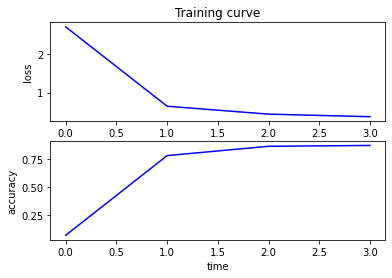

In [112]:
run_train(all_data, all_labels, backward_prop) 